# ETL

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import matplotlib
import folium
from folium import plugins
import seaborn as sns

In [2]:
# Carga de datos
hechos = pd.read_excel('../dataset/homicidios.xlsx', sheet_name='HECHOS')
victimas = pd.read_excel('../dataset/homicidios.xlsx', sheet_name='VICTIMAS')

In [3]:
hechos.head(5)

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,...,NaN,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,...,NaN,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,...,2034.0,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,...,NaN,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,SD
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,...,NaN,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS


In [4]:
victimas.head(5)

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01 00:00:00
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02 00:00:00
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03 00:00:00
3,2016-0004,2016-01-10,2016,1,10,CONDUCTOR,MOTO,MASCULINO,18,SD
4,2016-0005,2016-01-21,2016,1,21,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01 00:00:00


Limpieza de la columna `HORA`

In [5]:
# Imputando valores 0 a todo registro con SD
hechos['HORA'] = hechos['HORA'].replace('SD', 0 , regex=True)
# Creación de columnas auxiliares
hechos[['Hh', 'Mm', 'Ss']] = hechos['HORA'].str.split(':', expand=True)
hechos['Hh'] = hechos['Hh'].fillna(0).astype(int)
hechos['Mm'] = hechos['Mm'].fillna(0).astype(int)
hechos['Ss'] = hechos['Ss'].fillna(0).astype(int)

# Normalizado de la columna `HORA` al formato HH:MM:SS
hechos['HORA'] = hechos.apply(lambda row: f"{row['Hh']:02d}:{row['Mm']:02d}:{row['Ss']:02d}", axis=1)
# Eliminación de columnas auxiliares
hechos.drop('Hh', axis=1,inplace=True)
hechos.drop('Mm', axis=1,inplace=True)
hechos.drop('Ss', axis=1,inplace=True)

# Definir formato de variable entera
hechos['HH'] = pd.to_numeric(hechos['HH'],errors='coerce')

Limpieza de Datos Geoespaciales y Numéricos

In [6]:
hechos['pos x'] = pd.to_numeric(hechos['pos x'], errors='coerce')
hechos['pos x'] = hechos['pos x'].replace('.', pd.NA, regex=True)
hechos['pos y'] = pd.to_numeric(hechos['pos y'], errors='coerce')
hechos['pos y'] = hechos['pos y'].replace('.', pd.NA, regex=True)


Limpieza de datos para el dataframe `victimas`

In [7]:
victimas['EDAD'] = pd.to_numeric(victimas['EDAD'], errors='coerce', downcast='integer')
victimas['FECHA_FALLECIMIENTO'] = victimas['FECHA_FALLECIMIENTO'].replace('SD', pd.NA, regex=True)
victimas['FECHA_FALLECIMIENTO'] = pd.to_datetime(victimas['FECHA_FALLECIMIENTO']) 

Combinar dataframes haciendo coincidir `ID` y `ID_hecho`

In [8]:
df = pd.merge(hechos,victimas, left_on='ID', right_on='ID_hecho')

Eliminar columnas repetidas

In [9]:
df = df.drop(columns=['ID_hecho','FECHA_y','AAAA_y','MM_y','DD_y','VICTIMA_y'], axis=1)
nuevos_nombres ={'FECHA_x':'FECHA', 'AAAA_x':'AAAA', 'MM_x':'MM', 'DD_x':'DD', 'VICTIMA_x':'VICTIMA'}
df = df.rename(columns=nuevos_nombres)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     717 non-null    object        
 1   N_VICTIMAS             717 non-null    int64         
 2   FECHA                  717 non-null    datetime64[ns]
 3   AAAA                   717 non-null    int64         
 4   MM                     717 non-null    int64         
 5   DD                     717 non-null    int64         
 6   HORA                   717 non-null    object        
 7   HH                     716 non-null    float64       
 8   LUGAR_DEL_HECHO        717 non-null    object        
 9   TIPO_DE_CALLE          717 non-null    object        
 10  Calle                  716 non-null    object        
 11  Altura                 133 non-null    float64       
 12  Cruce                  540 non-null    object        
 13  Direc

In [11]:
df['Calle'].head(5)

0    PIEDRA BUENA AV.
1      PAZ, GRAL. AV.
2      ENTRE RIOS AV.
3      LARRAZABAL AV.
4        SAN JUAN AV.
Name: Calle, dtype: object

Crear una nueva columna 'Coordenadas' con el formato 'latitud, longitud'
Donde:

- `Latitud` corresponde a la columna `pos y`
- `Longitud` corresponde a la columna `pos x`

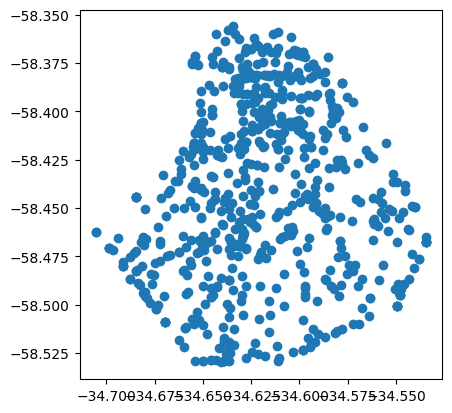

In [12]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Concatena las columnas 'pos y' y 'pos x' para obtener las coordenadas en formato "latitud, longitud"
hechos['Coordenadas'] = hechos.apply(lambda row: f"{row['pos y']}, {row['pos x']}", axis=1)

# Convierte las coordenadas en geometrías de tipo Point
hechos['geometry'] = hechos['Coordenadas'].apply(lambda x: Point(map(float, x.split(', '))))

# Crea un GeoDataFrame a partir del DataFrame 'hechos'
gdf = gpd.GeoDataFrame(hechos, geometry='geometry')

# Crea un mapa y muestra los puntos en el GeoDataFrame
gdf.plot()
plt.show()


Incluir columna Coordenadas en dataframe df

In [17]:
df['Coordenadas'] = hechos['Coordenadas']

Generar mapa de incidentes

In [13]:
# Calcula el promedio de las coordenadas 'pos x' y 'pos y' para centrar el mapa
lat_center = hechos['pos y'].mean()
lon_center = hechos['pos x'].mean()

# Crea un mapa centrado en la ubicación promedio
m = folium.Map(location=[lat_center, lon_center], zoom_start=12)

# Itera sobre las filas del DataFrame y agrega marcadores para coordenadas válidas
for index, row in hechos.iterrows():
    coordinates = row['Coordenadas']  # Asume que la columna 'coordenadas' contiene las coordenadas en formato 'latitud, longitud'
    if pd.notnull(coordinates):
        lat, lon = coordinates.split(', ')
        try:
            lat, lon = float(lat), float(lon)
            folium.Marker(location=[lat, lon]).add_to(m)
        except ValueError:
            print(f"Coordenadas no válidas: {coordinates}")

# Muestra el mapa interactivo
m
# m.save('mapa_con_marcadores.html')  # Esto guardará el mapa con marcadores en un archivo HTML

Coordenadas no válidas: nan, nan
Coordenadas no válidas: nan, nan
Coordenadas no válidas: nan, nan
Coordenadas no válidas: nan, nan
Coordenadas no válidas: nan, nan
Coordenadas no válidas: nan, nan
Coordenadas no válidas: nan, nan
Coordenadas no válidas: nan, nan
Coordenadas no válidas: nan, nan
Coordenadas no válidas: nan, nan
Coordenadas no válidas: nan, nan
Coordenadas no válidas: nan, nan


Variables numéricas

In [24]:
df.describe()

,N_VICTIMAS,FECHA,AAAA,MM,DD,HH,Altura,COMUNA,pos x,pos y,EDAD,FECHA_FALLECIMIENTO
count,717.000000,717,717.000000,717.000000,717.000000,716.000000,133.000000,717.000000,704.000000,704.000000,664.000000,649
mean,1.061367,2018-09-09 01:24:21.087866112,2018.174338,6.688982,15.953975,11.554469,3384.187970,7.430962,-58.441664,-34.619700,42.167169,2018-11-23 15:27:27.457627136
min,1.000000,2016-01-01 00:00:00,2016.000000,1.000000,1.000000,0.000000,30.000000,0.000000,-58.529942,-34.705250,1.000000,2016-01-01 00:00:00
25%,1.000000,2017-04-01 00:00:00,2017.000000,4.000000,9.000000,6.000000,1366.000000,4.000000,-58.476556,-34.643918,27.000000,2017-07-27 00:00:00
50%,1.000000,2018-07-07 00:00:00,2018.000000,7.000000,16.000000,11.000000,2639.000000,8.000000,-58.444513,-34.622866,37.000000,2018-09-21 00:00:00
75%,1.000000,2019-12-18 00:00:00,2019.000000,10.000000,23.000000,17.000000,4500.000000,11.000000,-58.401841,-34.597013,56.250000,2020-03-05 00:00:00
max,3.000000,2021-12-30 00:00:00,2021.000000,12.000000,31.000000,23.000000,16080.000000,15.000000,-58.356082,-34.534654,95.000000,2022-01-03 00:00:00
std,0.257024,NaN,1.672655,3.575140,8.674876,6.700055,3095.161836,4.385067,0.046397,0.035292,19.788034,NaN


In [28]:
df['N_VICTIMAS'].value_counts()

N_VICTIMAS
1    676
2     38
3      3
Name: count, dtype: int64

Distribución del numero de victimas

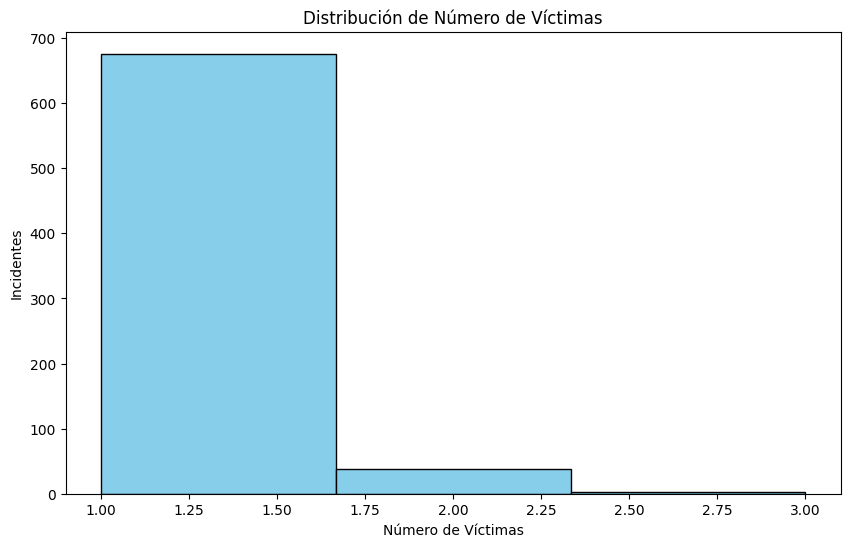

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(df['N_VICTIMAS'], bins=3, color='skyblue', edgecolor='black')  
plt.title('Distribución de Número de Víctimas')
plt.xlabel('Número de Víctimas')
plt.ylabel('Incidentes')

# Muestra el histograma
plt.show()


Distribución temporal de incidentes

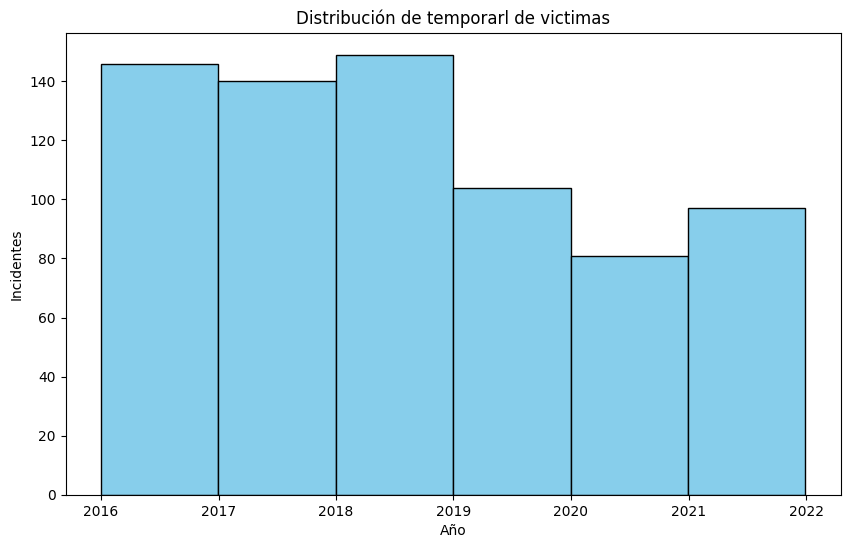

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(df['FECHA'], bins=6, color='skyblue', edgecolor='black')  
plt.title('Distribución de temporarl de victimas')
plt.xlabel('Año')
plt.ylabel('Incidentes')

# Muestra el histograma
plt.show()

Dispersion de datos para la variable Altura

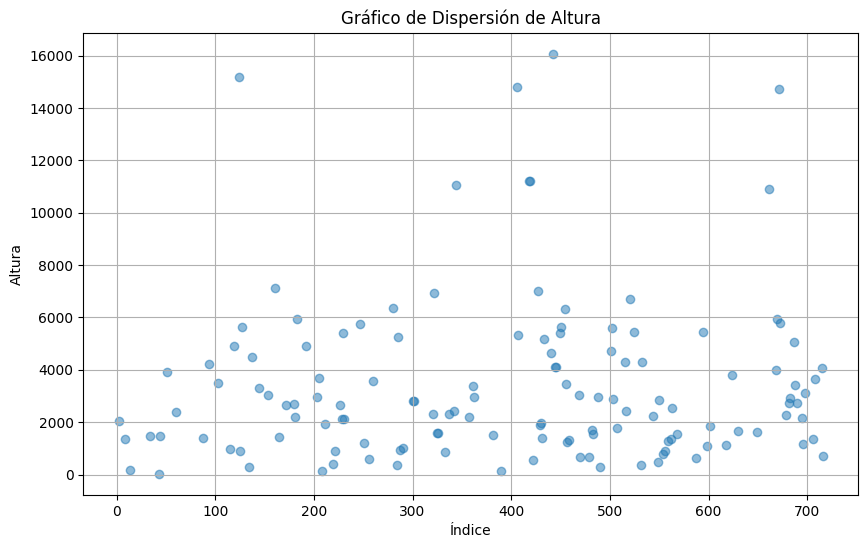

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['Altura'], alpha=0.5)
plt.title('Gráfico de Dispersión de Altura')
plt.xlabel('Índice')
plt.ylabel('Altura')
plt.grid(True)
plt.show()

Outliers de la variable EDAD

In [45]:
columna_edad = df['EDAD']
Q1 = columna_edad.quantile(0.25)
Q3 = columna_edad.quantile(0.75)

# Calcula el IQR (rango intercuartil)
IQR = Q3 - Q1

# Define los límites para identificar outliers
if Q1 - 1.5 * IQR < 0:
    limite_inferior = 0
else:
    limite_inferior = Q1 - 1.5 * IQR

limite_superior = Q3 + 1.5 * IQR

# Encuentra los outliers
outliers = columna_edad[(columna_edad > limite_inferior) & (columna_edad < limite_superior)]
columna_edad.describe()

count    664.000000
mean      42.167169
std       19.788034
min        1.000000
25%       27.000000
50%       37.000000
75%       56.250000
max       95.000000
Name: EDAD, dtype: float64

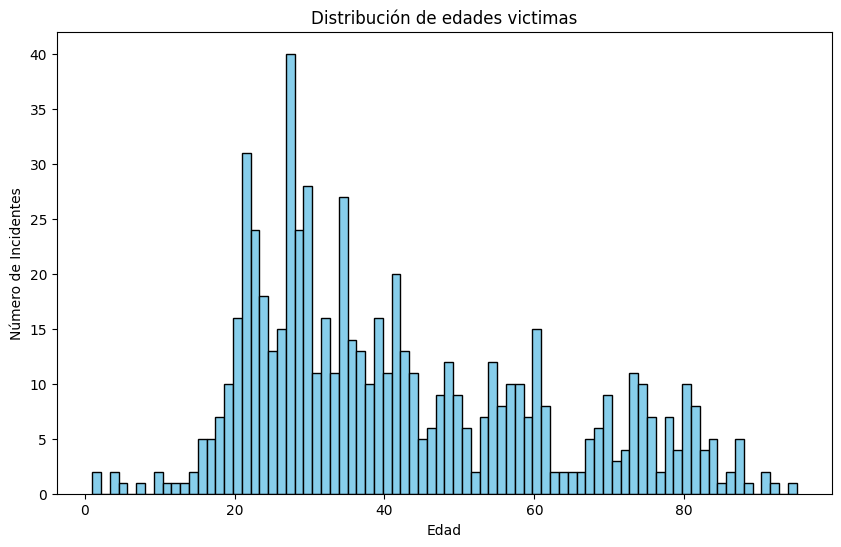

In [47]:
plt.figure(figsize=(10, 6))
plt.hist(df['EDAD'], bins=80, color='skyblue', edgecolor='black')  
plt.title('Distribución de edades victimas')
plt.xlabel('Edad')
plt.ylabel('Número de Incidentes')

# Muestra el histograma
plt.show()

Variables categoricas

In [23]:
df.describe(include='object')

,ID,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Cruce,Dirección Normalizada,XY (CABA),PARTICIPANTES,VICTIMA,ACUSADO,ROL,SEXO,Coordenadas
count,717,717,717,717,716,540,708,717,717,717,717,717,717,696
unique,696,75,683,4,279,317,635,606,41,10,10,5,3,605
top,2017-0035,00:00:00,AV 27 DE FEBRERO Y AV ESCALADA,AVENIDA,"PAZ, GRAL. AV.","PAZ, GRAL. AV.",27 DE FEBRERO AV. y ESCALADA AV.,Point (. .),PEATON-PASAJEROS,MOTO,AUTO,CONDUCTOR,MASCULINO,"nan, nan"
freq,3,630,4,442,61,14,5,15,105,302,210,330,545,12


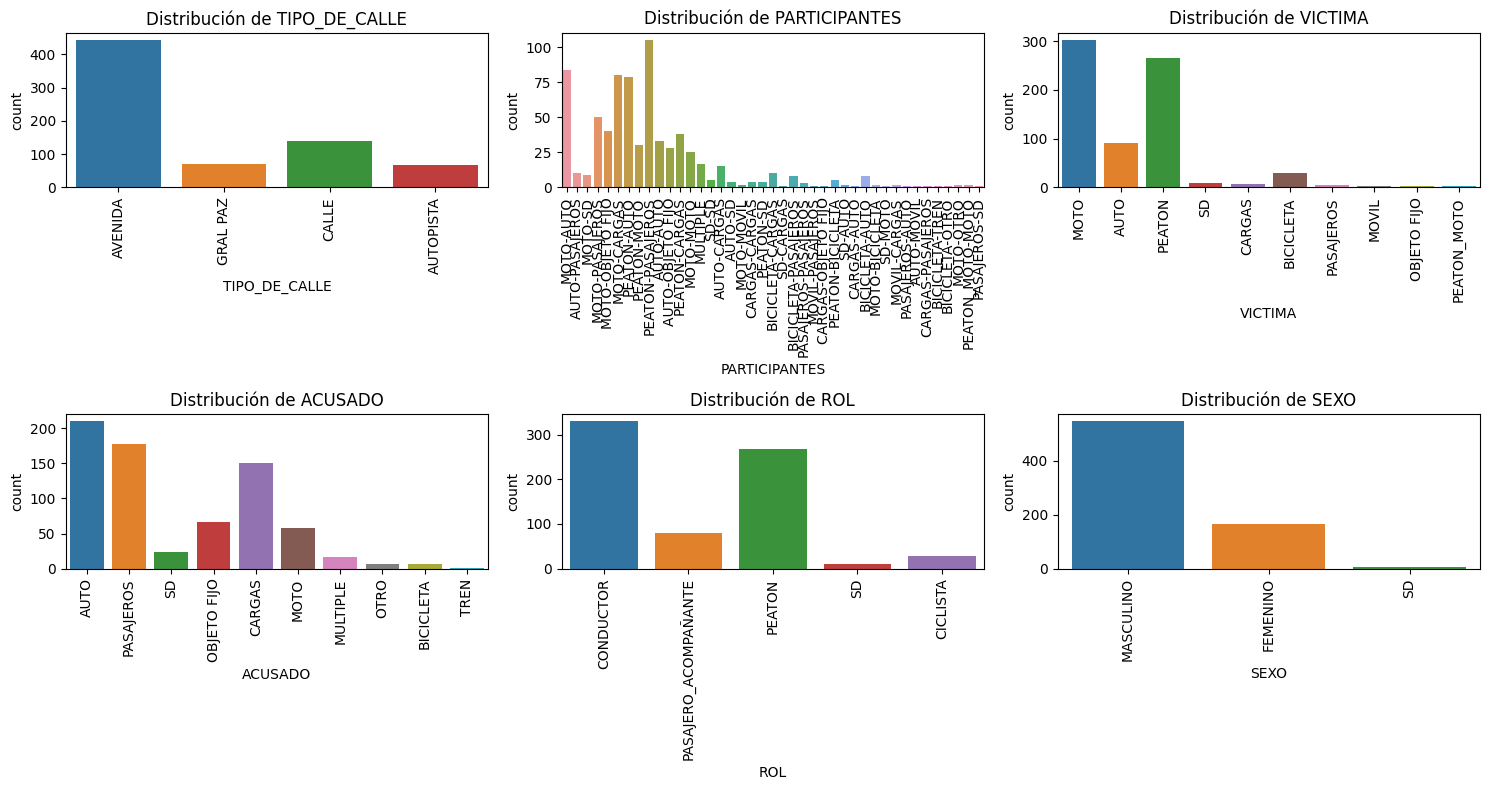

In [54]:
# Supongamos que estas son las columnas categóricas que deseas graficar
columnas_categoricas = ['TIPO_DE_CALLE','PARTICIPANTES', 'VICTIMA', 'ACUSADO', 'ROL', 'SEXO']

# Configura el tamaño de la figura
plt.figure(figsize=(15, 8))

# Genera subplots para cada columna categórica
for i, columna in enumerate(columnas_categoricas, 1):
    plt.subplot(2, 3, i)  # 2 filas, 3 columnas de subplots
    sns.countplot(data=df, x=columna)
    plt.title(f'Distribución de {columna}')
    plt.xticks(rotation=90)  # Rota las etiquetas del eje x para mayor legibilidad

# Ajusta el espaciado entre subplots
plt.tight_layout()

# Muestra los gráficos
plt.show()


Correlación entre variables

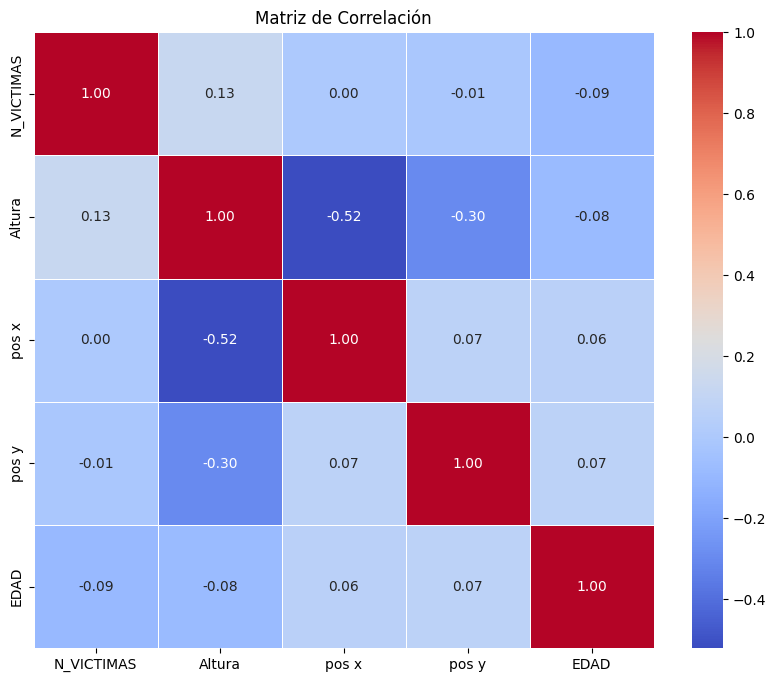

In [55]:
# Selecciona las variables numéricas
variables_numericas = df[['N_VICTIMAS', 'Altura', 'pos x', 'pos y', 'EDAD']]

# Calcula la matriz de correlación
matriz_correlacion = variables_numericas.corr()

# Crea un mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()


La población de la Ciudad de Buenos Aires (CABA) es extraida del reporte:
`Población total estimada por sexo, superficie y densidad poblacional según comuna. Ciudad de Buenos Aires. Años 2006/2022` 

Fuente: 
`Dirección General de Estadística y Censos (Ministerio de Hacienda y Finanzas GCBA). Proyecciones de población. Informe de resultados 789/2014.`

Disponible en https://www.estadisticaciudad.gob.ar/eyc/?p=76599

In [16]:
dic_CABA = [{'Año': 2016, 'Poblacion': 3059122},
            {'Año': 2017, 'Poblacion': 3063728},
            {'Año': 2018, 'Poblacion': 3068043},
            {'Año': 2019, 'Poblacion': 3072029},
            {'Año': 2020, 'Poblacion': 3075646},
            {'Año': 2021, 'Poblacion': 3078836}]
Poblacion_CABA = pd.DataFrame(dic_CABA)